In [16]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('/content/drive/MyDrive/ML Data Files/creditcard.csv')[:80_000]
df.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [17]:
df.shape

(80000, 31)

In [18]:
X = df.drop(columns=['Time','Amount','Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, # Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), # Fraud Cases=196'

In [ ]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0:1, 1:2}, max_iter=1000)

# class_weight={0:1, 1:2} --> since the data the very imbalanced we can assign 
# weights to the classes inside LogisticRegression

mod.fit(X,y).predict(X).sum()

171

Now that we have a setting we can optimize (class_weight={0:1, 1:2}), we can use GridSearchCV to optimize the class_weight setting

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0:1, 1:v} for v in range(1,4)]},
    cv=4
)

# param_grid--> iterating over a range 1:4 to find the optimal weight for 1:v
# where '1:v' indicates the weight for fraud data '1'

grid.fit(X,y)

In [ ]:
grid.cv_results_

In [ ]:
pd.DataFrame(grid.cv_results_)

Here GridSearchCV is giving some 'score' columns, but we did not mention any metrics. This comes from the LogisticRegression model which automatically imports accuracy_score (unless specified otherwise)

In [ ]:
lr = LogisticRegression()
??lr.score

# ***Now instead of accuracy_score we are more interested in precision_score, recall_score.***

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y, grid.predict(X))

precision_score --> given that I predict fraud how accurate am I? TP/(TP+FP)

recall_score--> did I get all the fraud cases? TP/(TP+FN)

Cases: 

1. extreme example where every single case is a fraud case then recall->high, precision->low

2. where only one case is fraud case then recall->low, precision->high

In [ ]:
recall_score(y, grid.predict(X))

0.5918367346938775

In [ ]:
from sklearn.metrics import make_scorer
# now adding precision and recall to GridSearch
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0:1, 1:v} for v in range(1,4)]},
    scoring={'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=4
)

# 'scoring' will tell scikitLearn to just keep track of the extra scores, 
# 'refit' will tell scikitLearn to fit the model to optimize the specified score
#  return_train_score=True will also show us the train scores along with test scores
grid.fit(X,y)

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:
# now doing a proper run

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0:1, 1:v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=10
)

grid.fit(X,y)

In [ ]:
pd.DataFrame(grid.cv_results_).head()

In [ ]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision']:
  plt.plot([_[1] for _ in df['param_class_weight']],
           df[score],
           label=score)

plt.legend();

# x-axis --> class weights
# y-axis --> scores

Now we can choose based on the scores what kind of model do we want,

High-precision model?, High-recall model?, or a balance between the two?(using scikitLearn F1 score)

**Or we can entirely make up our own metric, since scikitLearn does not support every single metric system out there**

In [ ]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall_score', 'mean_train_precision']:
  plt.scatter(x = [_[1] for _ in df['param_class_weight']],
              y = df[score.replace('test', 'train')],
              label=score   )

plt.legend();

# x-axis --> class weights
# y-axis --> scores

In [19]:
# making our own metric based on taking the minimum point of both recall and precision

def min_recall_precision(y_true, y_pred):
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  return min(recall, precision)

In [20]:
# now doing a proper run

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0:1, 1:v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score),
             'recall_score': make_scorer(recall_score),
             'min_both': make_scorer(min_recall_precision)},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)

grid.fit(X,y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': make_scorer(min_recall_precision),
                      'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

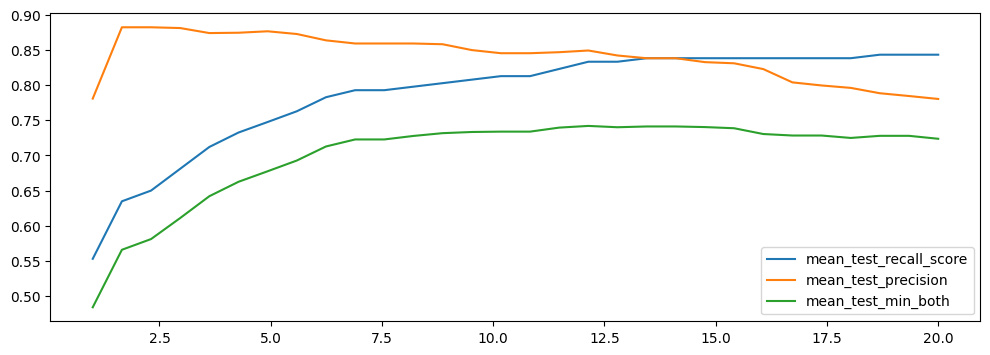

In [21]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_both']:
  plt.plot([_[1] for _ in df['param_class_weight']],
           df[score],
           label=score)

plt.legend();

In [22]:
# making the same metrics system but now it does not need 'make_scorer' to run

# here est->estimator->The estimator we put in GridSearchCV
# X, y_true-> training values; we input them when we use grid.fit(x,y)
# sample_weight-> assigns weights to chosen rows (rows that may hold more significance)

def min_recall_precision_scorer(est, X, y_true, sample_weight=None):
  y_pred = est.predict(X)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  return min(recall, precision)



In [25]:
df = pd.read_csv('/content/drive/MyDrive/ML Data Files/creditcard.csv')[:80_000]
X = df.drop(columns=['Time','Amount','Class']).values
y = df['Class'].values

In [27]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [28]:
# now doing a proper run without make_scorer

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0:1, 1:v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score),
             'recall_score': make_scorer(recall_score),
             'min_both': min_recall_precision_scorer},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)

grid.fit(X,y, sample_weight=np.log(1 + df['Amount']));

# we are assigning sample_weight here. Took log, so if there are very large data in 'Amount' (transaction $)
# 'log' will prevent those large data from dominating the model & overfitting to that large data.

In [39]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_both']:
  plt.plot([_[1] for _ in df['param_class_weight']],
           df[score],
           label=score)

plt.legend();

KeyError: ignored

<Figure size 1200x400 with 0 Axes>

In this dataset the fraud dataset is so little that it can be specified as outliers. Now using a outlier detection algorithm (IsolationForest) to find the outliers (presented as -1's)

In [32]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
print(mod.predict(X))
Counter(mod.predict(X))

# here 1 represents not an outlier, -1 represents outliers

[1 1 1 ... 1 1 1]


Counter({1: 76846, -1: 3154})

In [35]:
np.where(mod.predict(X) == -1, 1, 0)

# replace -1's(outlier) with the label '1' for fraud, and not -1's then replace with '0' for not fraud  

array([0, 0, 0, ..., 0, 0, 0])

Now if we want to use IsolationForest inside GridSearchCV; the code will break since the recall, recision score are expecting 1 or 0 not -1 or 1. So we will write our own varient of the recall and precision to pass into GridSearchCV

Custom Metrics


In [36]:
def outlier_precision(mod, X, y):
  preds = mod.predict(X)
  return precision_score(y, np.where(preds == -1, 1, 0))

# this is the same code as block [32] just with precision_score metric added

In [37]:
def outlier_recall(mod, X, y):
  preds = mod.predict(X)
  return recall_score(y, np.where(preds == -1, 1, 0))

In [38]:
grid = GridSearchCV(
    estimator= IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision,
             'recall_score': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)

grid.fit(X,y);

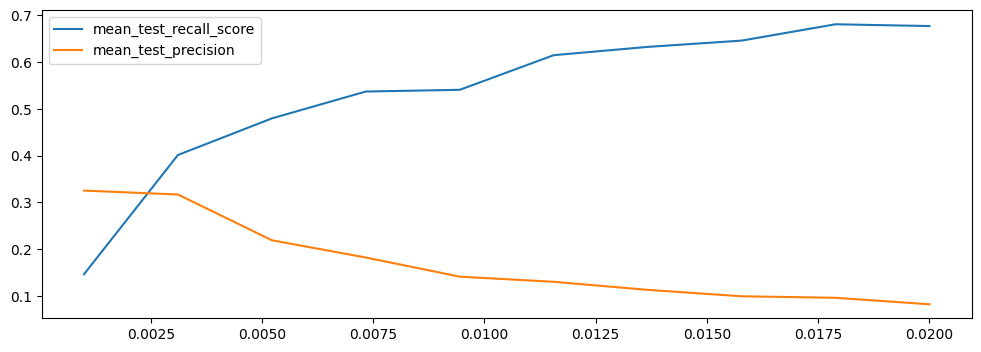

In [41]:
plt.figure(figsize=(12,4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision']:
  plt.plot(df_results['param_contamination'],
           df_results[score],
           label=score)

plt.legend();

Always read the descriptions of the objects that you call. These often have many changable features and options that are set True/False by default. This can massively impact your model, if the options inside the object is contradactory to the metrics you are using.

e.g. make_scorer has a option 'greater_is_better=True', which will always pick the greatest score make_scorer is receiving. This is ok if the metric/score is precision/recall since greater is better in this case. But if the metric is RMSE then the greater the RMSE the worse is the model. 

So always be mindful to fully understand what are the objects/functions you are using, and what is affecting what in all times.